In [13]:
pip install datasets tensorflow "transformers[sentencepiece]"

In [14]:
# Ignore annoying warnings
import warnings
warnings.filterwarnings("ignore")

# Training only classifier head - Model : "distilbert-base-uncased"

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.distilbert.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_119', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_119 (Dropout)       multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________


## Saving Model Weights of only classifier head trained model

In [4]:
model.save_weights('classifier_head_weights.h5')

# Keeping the trained Classifier head of the first part: Fine-tune **all** the weights

Using conventional approach


In [60]:
# Load the pre-trained model for fine-tuning all layers except the classifier
model_minus_classifier = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# Now load the weights saved back into the model
model_minus_classifier.load_weights('classifier_head_weights.h5', by_name=True)

# Set only the pre_classifier and classifier layer to non-trainable to preserve its weights
model_minus_classifier.pre_classifier.trainable = False
model_minus_classifier.classifier.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_minus_classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model_minus_classifier.summary()

history = model_minus_classifier.fit(
    tf_train_dataset,
    epochs=3,
    validation_data=tf_validation_dataset
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_minus_classifier.evaluate(tf_test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_519', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_519 (Dropout)       multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 592899 (2.26 MB)
_________________________________________________________________
Epoch 1/3
227/227 [=====================

**Training:**

* Total params: 66955779 (255.42 MB)
* Trainable params: 66362880 (253.15 MB)
* Non-trainable params: 592899 (2.26 MB)

**Result:**

* Test Loss: 0.195, Test Accuracy: 95.5%

# Fine-tune **only the weights** of the FFN blocks in every layer using LoRA technique

In [64]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig

class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, original_layer, rank):
        super(LoRALayer, self).__init__()
        self.original_layer = original_layer
        self.rank = rank
        self.input_dim = original_layer.kernel.shape[0]
        self.output_dim = original_layer.kernel.shape[1]

        # Initialize LoRA parameters
        self.A = self.add_weight(shape=(self.input_dim, rank), initializer='glorot_uniform', trainable=True)
        self.B = self.add_weight(shape=(rank, self.output_dim), initializer='glorot_uniform', trainable=True)
        self.lora_alpha = 1.0

    def call(self, inputs):
        # Compute the original output
        original_output = self.original_layer(inputs)

        # Compute the low-rank adaptation
        lora_update = self.lora_alpha * tf.matmul(inputs, tf.matmul(self.A, self.B))

        return original_output + lora_update

checkpoint = "distilbert-base-uncased"
model_lora = TFDistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# Load the previously saved weights into the model
model_lora.load_weights('classifier_head_weights.h5', by_name=True)

# Rank for LoRA matrices
lora_rank = 8

# Replace each lin1 and lin2 layer in each transformer layer with a LoRA-enhanced layer
for i, layer in enumerate(model_lora.distilbert.transformer.layer):
    original_lin1 = layer.ffn.lin1
    original_lin2 = layer.ffn.lin2
    layer.ffn.lin1 = LoRALayer(original_lin1, rank=lora_rank)
    layer.ffn.lin2 = LoRALayer(original_lin2, rank=lora_rank)

    original_lin1.trainable = False
    original_lin2.trainable = False

# Freeze weights of the classifier head
model_lora.pre_classifier.trainable = False
model_lora.classifier.trainable = False

# Freeze all other parameters except for the LoRA parameters
for layer in model_lora.distilbert.transformer.layer:
    layer.attention.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_lora.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model_lora.summary()

# Train the model
model_lora.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

test_loss, test_accuracy = model_lora.evaluate(tf_test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_599', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66731520  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_599 (Dropout)       multiple                  0         
                                                                 
Total params: 67324419 (256.82 MB)
Trainable params: 24222720 (92.40 MB)
Non-trainable params: 43101699 (164.42 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==================

**Training:**

* Total params: 67324419 (256.82 MB)

* Trainable params: 24222720 (92.40 MB)

* Non-trainable params: 43101699 (164.42 MB)

**Result:**

* Test Loss: 0.182, Test Accuracy: 93.3%

Interpretation:
LoRA is training just 33% weights as the conventional method but still getting a comparable accuracy to the conventional way of fine tuning

# Q) How does the performance of the model fine-tuned with LoRA compare to that of the pre-trained (not fine-tuned) model?

Getting out of sample accuracy for pre-trained distilBERT model (not fine-tuned)

In [63]:
# Load the pre-trained model for fine-tuning all layers except the classifier
model_without_pre_training = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)


initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_without_pre_training.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model_without_pre_training.summary()

# Evaluate the model on the test set
test_loss, test_accuracy = model_without_pre_training.evaluate(tf_test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_579', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_579 (Dropout)       multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
29/29 [==============================] - 8s

Result:

Accuracy for pre-trained model (Not fine tuned) : 13.2%

Accuracy for LoRA fine tuned model : 93.3%

Conclusion: Clearly LoRA fine tuned model is better

# Q) How does the performance of the model fine-tuned with LoRA compare to that of the model fine-tuned using the conventional approach?

Result:

Accuracy for fine tuned model using conventional approach (Train whole model except fine tuned head) : 95.5%

Accuracy for LoRA fine tuned model (Train whole model with LoRA except fine tuned head) : 93.3%

Conclusion: Both the models perform almost equally

# Q) How many LoRA parameters for each FFN block

Step 1: Calulate input and output dimensions (d_input and d_output) of the distilbert model

In [51]:
from transformers import TFDistilBertForSequenceClassification

checkpoint = "distilbert-base-uncased"
model = TFDistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# Retrieve the input and output dimensions from the first FFN block
d_input = model.distilbert.transformer.layer[0].ffn.lin1.kernel.shape[0]
d_output = model.distilbert.transformer.layer[0].ffn.lin1.kernel.shape[1]

print(f"Input dimension (d_input): {d_input}")
print(f"Output dimension (d_output): {d_output}")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_379', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Input dimension (d_input): 768
Output dimension (d_output): 3072


Result:

Input dimension (d_input): 768

Output dimension (d_output): 3072

Step 2: Calculate total LoRA parameters per FFN block

Parameters = (d_input * r) + (r * d_output)

where r is the rank used ie 8 in our code

In [50]:
r = 8  # Rank used for LoRA

# Calculate number of parameters for one FFN block (lin1 and lin2)
def calculate_lora_parameters(d_input, d_output, rank):
    return (d_input * rank) + (rank * d_output)

lora_params_per_layer = calculate_lora_parameters(d_input, d_output, r)

lora_params_per_ffn_block = lora_params_per_layer * 2

print(f"Number of LoRA parameters per layer: {lora_params_per_layer}")
print(f"Total LoRA parameters per FFN block: {lora_params_per_ffn_block}")

Number of LoRA parameters per layer: 30720
Total LoRA parameters per FFN block: 61440


Result:

Number of LoRA parameters per layer: 30720

Total LoRA parameters per FFN block: 61440

# Q) How many LoRA parameters total (number of FFN blocks times the LoRA parameters per block)

Step 1: Calculate number of transformer layers in distilbert model

In [52]:
from transformers import TFDistilBertForSequenceClassification

checkpoint = "distilbert-base-uncased"
model = TFDistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

num_layers = len(model.distilbert.transformer.layer)

print(f"Number of transformer layers: {num_layers}")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_399', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Number of transformer layers: 6


Result:

Number of transformer layers: 6

Step 2: Calculate total added parameters

Each transformer layer contains 1 FFN block that consists of two dense layers (lin1 and lin2)

*added_total = lora_params_per_ffn_block * num_layers*

In [53]:
added_total = lora_params_per_ffn_block * num_layers

print(f"Number of LoRA parameters per layer: {lora_params_per_layer}")
print(f"Total LoRA parameters per FFN block: {lora_params_per_ffn_block}")
print(f"Total added LoRA parameters across all FFN blocks: {added_total}")

Number of LoRA parameters per layer: 30720
Total LoRA parameters per FFN block: 61440
Total added LoRA parameters across all FFN blocks: 368640


Result:

Number of LoRA parameters per layer: 30720

Total LoRA parameters per FFN block: 61440

Total added LoRA parameters across all FFN blocks: 368640

# Q) How many total parameters in your model ?

Step 1: Calculate the total number of parameters in the unmodified DistilBERT model

In [54]:
from transformers import TFDistilBertForSequenceClassification

checkpoint = "distilbert-base-uncased"
model = TFDistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

def count_parameters(model):
    return sum(np.prod(v.shape) for v in model.trainable_weights)

# Calculate the total number of parameters in the unmodified DistilBERT model
original_params = count_parameters(model)

print(f"Original DistilBERT parameters: {original_params}")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_419', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Original DistilBERT parameters: 66955779


Result:

Original DistilBERT parameters: 66955779

Step 2: Calculate the Total parameters in the model <br>
*(total_parameters = original_params + added_total)*


In [55]:
# Total parameters in the model
total_parameters = original_params + added_total

print(f"Original DistilBERT parameters: {original_params}")
print(f"Added LoRA parameters: {added_total}")
print(f"Total parameters in the adapted model: {total_parameters}")

Original DistilBERT parameters: 66955779
Added LoRA parameters: 368640
Total parameters in the adapted model: 67324419


Result:

Original DistilBERT parameters: 66955779

Added LoRA parameters: 368640

Total parameters in the adapted model: 67324419

# assert(added_total == added_parms_calc)

In [58]:
from transformers import TFDistilBertForSequenceClassification

checkpoint = "distilbert-base-uncased"
model = TFDistilBertForSequenceClassification.from_pretrained(checkpoint)

d_input = model.distilbert.transformer.layer[0].ffn.lin1.kernel.shape[0]
d_output = model.distilbert.transformer.layer[0].ffn.lin1.kernel.shape[1]
num_layers = len(model.distilbert.transformer.layer)
r = 8  # Rank used for LoRA

def calculate_lora_parameters(d_input, d_output, rank):
    return (d_input * rank) + (rank * d_output)

lora_params_per_layer = calculate_lora_parameters(d_input, d_output, r)

lora_params_per_ffn_block = lora_params_per_layer * 2

added_parms_calc = lora_params_per_ffn_block * num_layers

added_total = added_parms_calc

# Assertion to verify the numbers match
assert(added_total == added_parms_calc)

print(f"Calculated trainable parameters added by LoRA: {added_parms_calc}")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_479', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Calculated trainable parameters added by LoRA: 368640


Result:

Calculated trainable parameters added by LoRA: 368640

Assertion is true!

# Experiment with the rank used in LoRA

Changing rank and checking accuracy

In [68]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig

class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, original_layer, rank):
        super(LoRALayer, self).__init__()
        self.original_layer = original_layer
        self.rank = rank
        self.input_dim = original_layer.kernel.shape[0]
        self.output_dim = original_layer.kernel.shape[1]

        # Initialize LoRA parameters
        self.A = self.add_weight(shape=(self.input_dim, rank), initializer='glorot_uniform', trainable=True)
        self.B = self.add_weight(shape=(rank, self.output_dim), initializer='glorot_uniform', trainable=True)
        self.lora_alpha = 1.0

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        lora_update = self.lora_alpha * tf.matmul(inputs, tf.matmul(self.A, self.B))
        return original_output + lora_update

# List of ranks to test
ranks = [2, 4, 8, 16, 32, 64]
test_losses = []
test_accuracies = []

for lora_rank in ranks:
    print(f"Training with LoRA rank: {lora_rank}")
    model_lora = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
    model_lora.load_weights('classifier_head_weights.h5', by_name=True)

    # Apply LoRA layers
    for i, layer in enumerate(model_lora.distilbert.transformer.layer):
        original_lin1 = layer.ffn.lin1
        original_lin2 = layer.ffn.lin2
        layer.ffn.lin1 = LoRALayer(original_lin1, rank=lora_rank)
        layer.ffn.lin2 = LoRALayer(original_lin2, rank=lora_rank)

        original_lin1.trainable = False
        original_lin2.trainable = False

    # Freeze classifier head
    model_lora.pre_classifier.trainable = False
    model_lora.classifier.trainable = False

    # Freeze all other parameters except for the LoRA parameters
    for layer in model_lora.distilbert.transformer.layer:
        layer.attention.trainable = False

    optimizer = tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=5e-5,
        decay_steps=10000,
        end_learning_rate=0.0,
        power=1.0
    ))
    model_lora.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    model_lora.summary()

    # Train the model
    model_lora.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

    # Evaluate the model
    test_loss, test_accuracy = model_lora.evaluate(tf_test_dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Rank: {lora_rank}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Training with LoRA rank: 2


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_679', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66455040  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_679 (Dropout)       multiple                  0         
                                                                 
Total params: 67047939 (255.77 MB)
Trainable params: 23946240 (91.35 MB)
Non-trainable params: 43101699 (164.42 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==================

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_699']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66547200  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_699 (Dropout)       multiple                  0         
                                                                 
Total params: 67140099 (256.12 MB)
Trainable params: 24038400 (91.70 MB)
Non-trainable params: 43101699 (164.42 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==================

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_719', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66731520  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_719 (Dropout)       multiple                  0         
                                                                 
Total params: 67324419 (256.82 MB)
Trainable params: 24222720 (92.40 MB)
Non-trainable params: 43101699 (164.42 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==================

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_739', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  67100160  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_739 (Dropout)       multiple                  0         
                                                                 
Total params: 67693059 (258.23 MB)
Trainable params: 24591360 (93.81 MB)
Non-trainable params: 43101699 (164.42 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==================

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_759', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  67837440  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_759 (Dropout)       multiple                  0         
                                                                 
Total params: 68430339 (261.04 MB)
Trainable params: 25328640 (96.62 MB)
Non-trainable params: 43101699 (164.42 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==================

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_779']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_distil_bert_for_sequence_classification_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  69312000  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_779 (Dropout)       multiple                  0         
                                                                 
Total params: 69904899 (266.67 MB)
Trainable params: 26803200 (102.25 MB)
Non-trainable params: 43101699 (164.42 MB)
_________________________________________________________________
Epoch 1/3
227/227 [=================

Result:


| Rank | Total Parameters | Trainable Parameters | Non-trainable Parameters | Test Loss | Test Accuracy |
|------|------------------|----------------------|--------------------------|-----------|---------------|
| 2    | 67,047,939       | 23,946,240           | 43,101,699               | 0.2493    | 91.63%        |
| 4    | 67,140,099       | 24,038,400           | 43,101,699               | 0.2167    | 92.95%        |
| 8    | 67,324,419       | 24,222,720           | 43,101,699               | 0.1913    | 94.27%        |
| 16   | 67,693,059       | 24,591,360           | 43,101,699               | 0.1646    | 94.27%        |
| 32   | 68,430,339       | 25,328,640           | 43,101,699               | 0.1506    | 95.59%        |
| 64   | 69,904,899       | 26,803,200           | 43,101,699               | 0.1438    | 95.15%        |


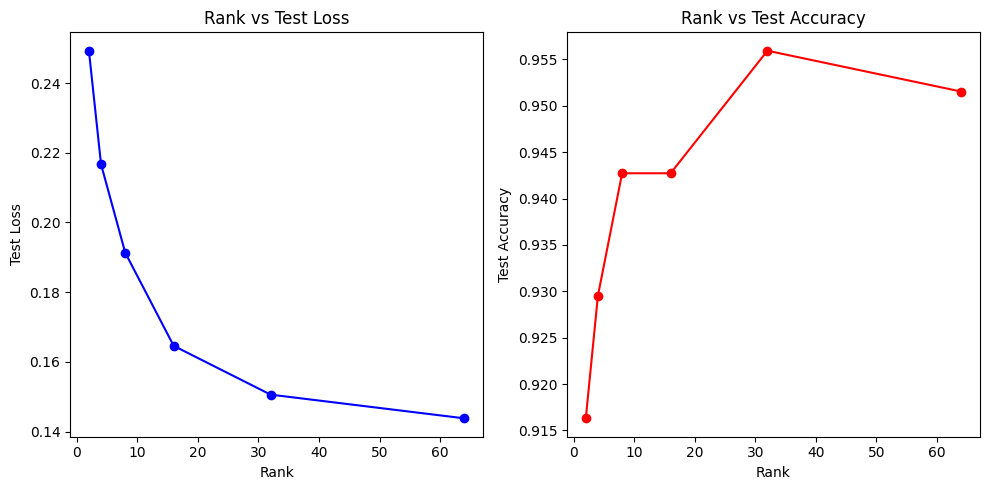

In [69]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ranks, test_losses, marker='o', color='b')
plt.title('Rank vs Test Loss')
plt.xlabel('Rank')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(ranks, test_accuracies, marker='o', color='r')
plt.title('Rank vs Test Accuracy')
plt.xlabel('Rank')
plt.ylabel('Test Accuracy')

plt.tight_layout()
plt.show()

As the rank as increase we can see an increase in accuracy but up to a point and after that it decreases as it might be overfitting.

Increasing the rank is also increasing the computational resource required to train the model
